# Tarefa: Deep autoencoder na base CIFAR-10

Agora que você aprendeu a construir três tipos de autoencoders com o PyTorch aplicados na base de dados MNIST, é hora de trabalhar com uma base de dados mais complexa. Portanto, o objetivo é construir um deep autoencoder utilizando a base de dados cifar10 que possui imagens de aviões, automóveis, pássaros, gatos, veados, cachorros, sapos, cavalos, barcos e caminhões. Siga as seguintes dicas:

- As dimensões das imagens são 32 x 32 e possuem 3 canais por serem coloridas. Por isso, a quantidade total de dados de cada imagem é de 3072 (que equivale a quantidade de neurônios na camada de entrada e camada de saída)

- Você pode criar duas camadas ocultas para este experimento (para que o tempo de processamento não seja tão alto assim)

- Dica para criação das camadas: como temos 3072 entradas, você pode sempre dividir por dois para definir a quantidade de neurônios em cada camada oculta. Por exemplo: 3072 / 2 = 1536, 1536 / 2 = 768 e assim por diante

O objetivo no final é comparar as imagens originais com as imagens decodificadas. Abaixo você pode visualizar o resultado que obtivemos

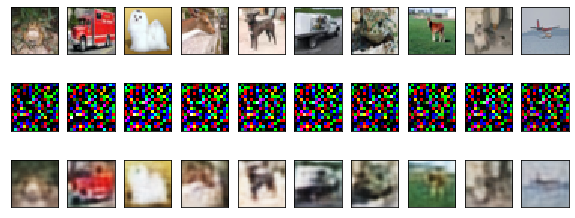

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

## Etapa 1: Importação das bibliotecas

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [4]:
data_train = datasets.CIFAR10('CIFAR10-data', train = True, download=True,
                               transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(data_train, batch_size=256,
                                           shuffle = True)

Files already downloaded and verified


In [5]:
data_test = datasets.CIFAR10('CIFAR10-data', train = False, download=True,
                           transform = transforms.ToTensor())
loader_test = torch.utils.data.DataLoader(data_test, batch_size=256,
                                          shuffle=True)

Files already downloaded and verified


## Etapa 3: Construção do autoencoder

In [6]:
data_test.data[0].shape

(32, 32, 3)

In [42]:
# Imagens 32 x 32 x 3 = 3072
# 3072 -> 768 -> 192 -> 48 -> 192 -> 168 -> 30721
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # CAMADA DO ENCODER
    self.encoder0 = nn.Linear(in_features=3072, out_features=1536)
    self.encoder1 = nn.Linear(1536,768)

    # CAMADA DO DECODER
    self.decoder0 = nn.Linear(768,1536)
    self.decoder1 = nn.Linear(1536,3072)

    # CAMADAS DE ATIVAÇÃO
    self.activation0 = nn.ReLU()
    self.activation1 = nn.Sigmoid()

  def forward(self, X):
    # ESTRUTURA DO ENCODER    
    X = self.activation0(self.encoder0(X))
    X = self.activation0(self.encoder1(X))

    # ESTRUTURA DO DECODER
    X = self.activation0(self.decoder0(X))
    X = self.activation1(self.decoder1(X))
    return X

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [44]:
model = autoencoder()
model.to(device)

autoencoder(
  (encoder0): Linear(in_features=3072, out_features=1536, bias=True)
  (encoder1): Linear(in_features=1536, out_features=768, bias=True)
  (decoder0): Linear(in_features=768, out_features=1536, bias=True)
  (decoder1): Linear(in_features=1536, out_features=3072, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [45]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [48]:
for epoch in range(100):
  # TREINAMENTO
  running_loss_train = 0.
  for data in loader_train:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)
    inputs = inputs.view(-1, 3072)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    loss.backward()

    optimizer.step()

    running_loss_train += loss.item()

  # VALIDAÇÃO
  running_loss_val = 0.
  for data in loader_test:
    model.eval()
    inputs, _ = data
    inputs = inputs.to(device)
    inputs = inputs.view(-1, 3072)
    
    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    running_loss_val += loss.item()

  print('ÉPOCA {:3d}: PERDA TREINO {:.5f} | PERDA VALIDAÇÃO {:.5f}' \
        .format(epoch+1, running_loss_train/len(loader_train), running_loss_val/len(loader_test)))

ÉPOCA   1: PERDA TREINO 0.57613 | PERDA VALIDAÇÃO 0.58207
ÉPOCA   2: PERDA TREINO 0.57513 | PERDA VALIDAÇÃO 0.57533
ÉPOCA   3: PERDA TREINO 0.57446 | PERDA VALIDAÇÃO 0.57438
ÉPOCA   4: PERDA TREINO 0.57348 | PERDA VALIDAÇÃO 0.57553
ÉPOCA   5: PERDA TREINO 0.57288 | PERDA VALIDAÇÃO 0.57323
ÉPOCA   6: PERDA TREINO 0.57217 | PERDA VALIDAÇÃO 0.57396
ÉPOCA   7: PERDA TREINO 0.57146 | PERDA VALIDAÇÃO 0.57256
ÉPOCA   8: PERDA TREINO 0.57110 | PERDA VALIDAÇÃO 0.57208
ÉPOCA   9: PERDA TREINO 0.57063 | PERDA VALIDAÇÃO 0.57139
ÉPOCA  10: PERDA TREINO 0.57015 | PERDA VALIDAÇÃO 0.57120
ÉPOCA  11: PERDA TREINO 0.56974 | PERDA VALIDAÇÃO 0.57143
ÉPOCA  12: PERDA TREINO 0.56944 | PERDA VALIDAÇÃO 0.56975
ÉPOCA  13: PERDA TREINO 0.56868 | PERDA VALIDAÇÃO 0.56887
ÉPOCA  14: PERDA TREINO 0.56844 | PERDA VALIDAÇÃO 0.57142
ÉPOCA  15: PERDA TREINO 0.56833 | PERDA VALIDAÇÃO 0.56876
ÉPOCA  16: PERDA TREINO 0.56751 | PERDA VALIDAÇÃO 0.56987
ÉPOCA  17: PERDA TREINO 0.56744 | PERDA VALIDAÇÃO 0.56878
ÉPOCA  18: PER

## Etapa 5: Geração do encoder

In [49]:
list(model.children())

[Linear(in_features=3072, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=768, bias=True),
 Linear(in_features=768, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=3072, bias=True),
 ReLU(),
 Sigmoid()]

In [50]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder0 = list(model.children())[0]     # Linear => 3072 -> 1536
    self.encoder1 = list(model.children())[1]     # Linear => 1536 -> 768
    self.activation0 = list(model.children())[4]  # RELU

  def forward(self, X):
    X = self.activation0(self.encoder0(X))
    X = self.activation0(self.encoder1(X))
    return X

In [51]:
model_enc = encoder()
model_enc.to(device)

encoder(
  (encoder0): Linear(in_features=3072, out_features=1536, bias=True)
  (encoder1): Linear(in_features=1536, out_features=768, bias=True)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [52]:
list(model.children())

[Linear(in_features=3072, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=768, bias=True),
 Linear(in_features=768, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=3072, bias=True),
 ReLU(),
 Sigmoid()]

In [53]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder0 = list(model.children())[2]       # Linear => 768 -> 1536
    self.decoder1 = list(model.children())[3]       # Linear => 1536 -> 3072
    self.activation0 = list(model.children())[4]    # Relu
    self.activation1 = list(model.children())[5]    # Sigmoid

  def forward(self, X):
    X = self.activation0(self.decoder0(X))
    X = self.activation0(self.decoder1(X))
    return X

In [54]:
model_dec = decoder()
model_dec.to(device)

decoder(
  (decoder0): Linear(in_features=768, out_features=1536, bias=True)
  (decoder1): Linear(in_features=1536, out_features=3072, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [63]:
num_images = 10
img_test = next(iter(loader_test))[0][:num_images]
img_test = img_test.to(device)
img_test = img_test.view(-1, 3072)

In [64]:
img_test.shape

torch.Size([10, 3072])

In [65]:
model_enc.eval()
img_cod = model_enc(img_test)

In [66]:
img_cod.shape

torch.Size([10, 768])

In [67]:
model_dec.eval()
img_dec = model_dec(img_cod)

In [68]:
img_dec.shape

torch.Size([10, 3072])

In [69]:
img_test = img_test.view(-1, 3, 32, 32).permute(0, 2, 3, 1).detach().cpu().numpy()
img_cod = img_cod.view(-1, 3, 16, 16).permute(0, 2, 3, 1).detach().cpu().numpy()
img_dec = img_dec.view(-1, 3, 32, 32).permute(0, 2, 3, 1).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

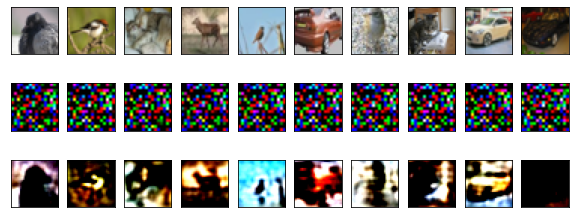

In [72]:
fig, axes = plt.subplots(3, num_images, figsize=(10,4))
for images, ax_row in zip([img_test, img_cod, img_dec], axes):
  for img,ax in zip(images, ax_row):
    ax.imshow(img,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()